In [106]:
# !pip install statsmodels
# !pip install seaborn

In [107]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


In [108]:
# Specify the path to the CSV file
file_path = 'C:/Users/bakwe/Desktop/BSE/Text_mining/HW1/Scraped_data/Barcelona_25_01.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Adding 'barcelona' column with values equal to 1
df['barcelona'] = 1

# Adding the 'event' column with values equal to 1
df['event'] = 1

# Display the DataFrame
print(df.shape)

(373, 10)


In [109]:
# Specify the path to the CSV file
file_path = 'C:/Users/bakwe/Desktop/BSE/Text_mining/HW1/Scraped_data/Valencia_25_01.csv'

# Read the CSV file into a DataFrame
V1 = pd.read_csv(file_path)

# Adding rows from V1 to df with 'barcelona' values set to 0 and 'event' values set to 1
df = pd.concat([df, V1.assign(barcelona=0, event=1)], ignore_index=True)

# Displaying the updated df DataFrame
print("\nUpdated df after adding rows from V1:")
print(df.shape)



Updated df after adding rows from V1:
(770, 10)


In [110]:
# Specify the path to the CSV file
file_path = 'C:/Users/bakwe/Desktop/BSE/Text_mining/HW1/Scraped_data/Valencia_19_24.csv'

# Read the CSV file into a DataFrame
V0 = pd.read_csv(file_path)

# Adding rows from V1 to df with 'barcelona' values set to 0 and 'event' values set to 0
df = pd.concat([df, V0.assign(barcelona=0, event=0)], ignore_index=True)

# Displaying the updated df DataFrame
print("\nUpdated df after adding rows from V1:")
print(df.shape)


Updated df after adding rows from V1:
(1167, 10)


In [111]:
# Specify the path to the CSV file
file_path = 'C:/Users/bakwe/Desktop/BSE/Text_mining/HW1/Scraped_data/Barcelona_19_24.csv'

# Read the CSV file into a DataFrame
B0 = pd.read_csv(file_path)

# Adding rows from B0 to df with 'barcelona' values set to 1 and 'event' values set to 0
df = pd.concat([df, B0.assign(barcelona=1, event=0)], ignore_index=True)

# Displaying the updated df DataFrame
print("\nUpdated df after adding rows from V1:")
print(df.shape)
print(df.columns)


Updated df after adding rows from V1:
(1605, 10)
Index(['Hotels', 'Ratings', 'Distance', 'District', 'Price', 'Link', 'Star',
       'Descriptions', 'barcelona', 'event'],
      dtype='object')


In [112]:
# Create a DataFrame
df = pd.DataFrame(df)

In [113]:
# First, count the occurrences of each value in the 'Hotels' column
hotel_counts = df['Hotels'].value_counts()

# Then, create a new DataFrame containing only rows with 'Hotels' values that appear twice
df = df[df['Hotels'].isin(hotel_counts[hotel_counts == 2].index)]

# Finally, print the count of 'Hotels' values
print(df['Hotels'].value_counts())

# df_filt = df[df['Hotels'].isin(hotel_counts[hotel_counts == 4].index)]
# print(df_filt)

# Ramirez Flats Valencia

Hotels
apartment next to park guell                       2
Casa Clarita                                       2
DWO Valencia                                       2
Carrer de l'Arquitecte Alfaro 27 bajo derecha      2
SingularStays Mercado Central                      2
                                                  ..
Praktik Garden                                     2
BacHome Terrace B&B                                2
Zenit Borrell                                      2
Sercotel Caspe                                     2
Precioso apartamento junto al centro con garaje    2
Name: count, Length: 294, dtype: int64


In [114]:
df[df['Hotels'] =='Casa Clarita']

,Hotels,Ratings,Distance,District,Price,Link,Star,Descriptions,barcelona,event
484,Casa Clarita,"9,2","a 0,5 km del centro",NaN,€ 841,https://www.booking.com/hotel/es/casa-clarita-...,4 de 5,Casa Clarita es un alojamiento con una ubicaci...,0,1
942,Casa Clarita,"9,2","a 0,5 km del centro",NaN,€ 615,https://www.booking.com/hotel/es/casa-clarita-...,4 de 5,Casa Clarita es un alojamiento con una ubicaci...,0,0


In [115]:
# # Find the 'Price' value when 'Hotels' is equal to 'Ohla Barcelona'
# ohla_barcelona_price = df.loc[df['Hotels'] == 'Ohla Barcelona', 'Price'].values[0]

# # Print the 'Price' value
# print("Price for 'Hotels' == 'Ohla Barcelona':", ohla_barcelona_price)

In [116]:
# Extract only digits from the 'Price' column and convert to numeric
df['Price'] = pd.to_numeric(df['Price'].str.replace('[^\d]', '', regex=True), errors='coerce')

# Extract the first digit and convert to numeric
df['Star'] = pd.to_numeric(df['Star'].str.extract('(\d)', expand=False), errors='coerce')

# Display the updated DataFrame
print(df.head())

                          Hotels Ratings             Distance  District  \
0   apartment next to park guell     9,0  a 2,7 km del centro       NaN   
1     Melia Barcelona Sky 4* Sup     8,2  a 3,3 km del centro       NaN   
3   Mercedes Heritage Apartments     8,5  a 1,5 km del centro       NaN   
5                Hostal Boqueria     8,4  a 0,6 km del centro       NaN   
6  The Streets Apartments Rambla     9,2    a 1 km del centro       NaN   

   Price                                               Link  Star  \
0   1608  https://www.booking.com/hotel/es/apartment-par...     4   
1   3343  https://www.booking.com/hotel/es/melia-barcelo...     4   
3   3565  https://www.booking.com/hotel/es/provenza-mbs....     2   
5   1657  https://www.booking.com/hotel/es/hostal-boquer...     4   
6   2654  https://www.booking.com/hotel/es/the-streets-a...     4   

                                        Descriptions  barcelona  event  
0  Apartment next to park guell se encuentra en B...         

In [117]:
# # Find the 'Price' value when 'Hotels' is equal to 'Ohla Barcelona'
# ohla_barcelona_price = df.loc[df['Hotels'] == 'Ohla Barcelona', 'Price'].values[0]

# # Print the 'Price' value
# print("Price for 'Hotels' == 'Ohla Barcelona':", ohla_barcelona_price)

In [118]:
# Display the count of NaN values in each column
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 588 entries, 0 to 1601
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Hotels        588 non-null    object 
 1   Ratings       588 non-null    object 
 2   Distance      588 non-null    object 
 3   District      0 non-null      float64
 4   Price         588 non-null    int64  
 5   Link          588 non-null    object 
 6   Star          588 non-null    int64  
 7   Descriptions  588 non-null    object 
 8   barcelona     588 non-null    int64  
 9   event         588 non-null    int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 50.5+ KB
None


In [119]:
# Group the DataFrame by 'barcelona' and 'event' columns and calculate the mean of 'Price'
result = df.groupby(['barcelona', 'event'])['Price'].mean().reset_index()

# Order the result DataFrame by the 'Star' column
# result = result.sort_values(by=['Star'])

# 'result' will now contain the average 'Price' for each combination of 'barcelona' and 'event'
print(result)

   barcelona  event        Price
0          0      0   566.049689
1          0      1   729.418605
2          1      0   688.758065
3          1      1  1912.236641


In [120]:
# Count the occurrences of each unique value in the 'Star' column
star_counts = df['Star'].value_counts()

# Print the count of values for each unique 'Star'
print(star_counts)

Star
4    310
3    191
2     52
1     21
5     14
Name: count, dtype: int64


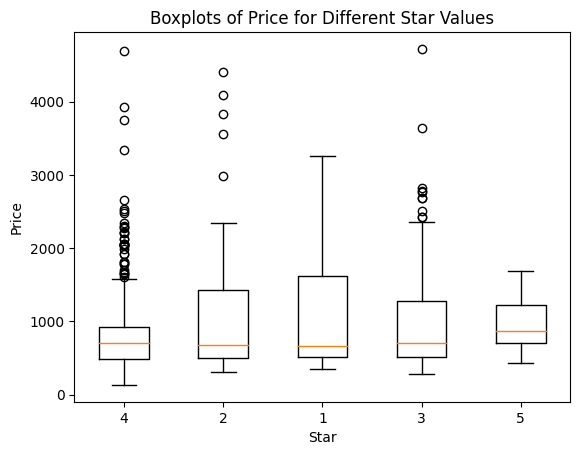

In [121]:
# Group the DataFrame by the 'Star' column and create boxplots for each group
plt.boxplot([df['Price'][df['Star'] == star] for star in df['Star'].unique()], 
            labels=df['Star'].unique())
plt.xlabel('Star')
plt.ylabel('Price')
plt.title('Boxplots of Price for Different Star Values')
plt.show()

In [122]:
# Independent variables
X = df[['barcelona']]

# Dependent variable
y = df['Price']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.551
Model:                            OLS   Adj. R-squared (uncentered):              0.551
Method:                 Least Squares   F-statistic:                              721.6
Date:                Thu, 01 Feb 2024   Prob (F-statistic):                   2.91e-104
Time:                        01:17:52   Log-Likelihood:                         -4751.8
No. Observations:                 588   AIC:                                      9506.
Df Residuals:                     587   BIC:                                      9510.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [123]:
# Independent variables
X = df[['event']]

# Dependent variable
y = df['Price']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.581
Model:                            OLS   Adj. R-squared (uncentered):              0.581
Method:                 Least Squares   F-statistic:                              815.1
Date:                Thu, 01 Feb 2024   Prob (F-statistic):                   4.52e-113
Time:                        01:17:52   Log-Likelihood:                         -4731.5
No. Observations:                 588   AIC:                                      9465.
Df Residuals:                     587   BIC:                                      9469.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [124]:
# Adding the interaction term
df['interaction_term'] = df['barcelona'] * df['event']

# Independent variables
X = df[['barcelona', 'event', 'interaction_term']]

# Dependent variable
y = df['Price']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.784
Model:                            OLS   Adj. R-squared (uncentered):              0.783
Method:                 Least Squares   F-statistic:                              709.0
Date:                Thu, 01 Feb 2024   Prob (F-statistic):                   2.49e-194
Time:                        01:17:52   Log-Likelihood:                         -4536.6
No. Observations:                 588   AIC:                                      9079.
Df Residuals:                     585   BIC:                                      9092.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [125]:
# Adding the interaction term
df['interaction_term'] = df['barcelona'] * df['event']

# Independent variables
X = df[['barcelona', 'event', 'interaction_term']]

# Dependent variable
y = df['Price']

# Adding a constant term to the independent variables
# X = sm.add_constant(X)

# Fit the regression model without adding a constant term
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.784
Model:                            OLS   Adj. R-squared (uncentered):              0.783
Method:                 Least Squares   F-statistic:                              709.0
Date:                Thu, 01 Feb 2024   Prob (F-statistic):                   2.49e-194
Time:                        01:17:52   Log-Likelihood:                         -4536.6
No. Observations:                 588   AIC:                                      9079.
Df Residuals:                     585   BIC:                                      9092.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [126]:
# Adding the interaction term
df['interaction_term'] = df['barcelona'] * df['event']

# Independent variables
X = df[['barcelona', 'event', 'Star', 'interaction_term']]

# Dependent variable
y = df['Price']

# Adding a constant term to the independent variables
# X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.843
Model:                            OLS   Adj. R-squared (uncentered):              0.842
Method:                 Least Squares   F-statistic:                              785.0
Date:                Thu, 01 Feb 2024   Prob (F-statistic):                   2.79e-233
Time:                        01:17:52   Log-Likelihood:                         -4442.8
No. Observations:                 588   AIC:                                      8894.
Df Residuals:                     584   BIC:                                      8911.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [127]:
# Create a new column 'Top_star' based on the condition
df['Top_star'] = (df['Star'].isin([4, 5])).astype(int)


In [128]:
# Calculate the number of observations meeting the specified conditions
num_observations = df[(df['barcelona'] == 1) & (df['Top_star'] == 1) & (df['event'] == 1)].shape[0]

# Display the result
print("Number of observations:", num_observations)

Number of observations: 50


In [129]:
# Adding the interaction term
df['interaction_term'] = df['barcelona'] * df['event']

# Independent variables
X = df[['barcelona', 'event', 'Top_star', 'interaction_term']]

# Dependent variable
y = df['Price']

# Adding a constant term to the independent variables
# X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.813
Model:                            OLS   Adj. R-squared (uncentered):              0.811
Method:                 Least Squares   F-statistic:                              633.5
Date:                Thu, 01 Feb 2024   Prob (F-statistic):                   9.17e-211
Time:                        01:17:52   Log-Likelihood:                         -4495.1
No. Observations:                 588   AIC:                                      8998.
Df Residuals:                     584   BIC:                                      9016.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [130]:
# Adding interaction terms
df['interaction_term'] = df['barcelona'] * df['event']
df['interaction_term_all'] = df['barcelona'] * df['event'] * df['Top_star']

# Independent variables
X = df[['barcelona', 'event', 'Top_star', 'interaction_term', 'interaction_term_all']]

# Dependent variable
y = df['Price']

# Adding a constant term to the independent variables
# X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.816
Model:                            OLS   Adj. R-squared (uncentered):              0.815
Method:                 Least Squares   F-statistic:                              517.6
Date:                Thu, 01 Feb 2024   Prob (F-statistic):                   1.09e-211
Time:                        01:17:52   Log-Likelihood:                         -4489.6
No. Observations:                 588   AIC:                                      8989.
Df Residuals:                     583   BIC:                                      9011.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

The codes below are ugly, i'll put it in loops later on

In [131]:
# Specify the path to the CSV file
file_path = 'C:/Users/bakwe/Desktop/BSE/Text_mining/HW1/Scraped_data/Barcelona_14_18.csv'

# Read the CSV file into a DataFrame
B__1 = pd.read_csv(file_path)

# Adding rows from V1 to df with 'barcelona' values set to 0 and 'event' values set to 1
df = pd.concat([df, B__1.assign(barcelona=1, event=-1)], ignore_index=True)

# Displaying the updated df DataFrame
print("\nUpdated df after adding rows from V1:")
print(df.shape)


Updated df after adding rows from V1:
(1021, 13)


In [132]:
# Specify the path to the CSV file
file_path = 'C:/Users/bakwe/Desktop/BSE/Text_mining/HW1/Scraped_data/Barcelona_09_13.csv'

# Read the CSV file into a DataFrame
B__2 = pd.read_csv(file_path)

# Adding rows from V1 to df with 'barcelona' values set to 0 and 'event' values set to 1
df = pd.concat([df, B__2.assign(barcelona=1, event=-2)], ignore_index=True)

# Displaying the updated df DataFrame
print("\nUpdated df after adding rows from V1:")
print(df.shape)


Updated df after adding rows from V1:
(1451, 13)


In [133]:
# Specify the path to the CSV file
file_path = 'C:/Users/bakwe/Desktop/BSE/Text_mining/HW1/Scraped_data/Valencia_09_13.csv'

# Read the CSV file into a DataFrame
V__2 = pd.read_csv(file_path)

# Adding rows from V1 to df with 'barcelona' values set to 0 and 'event' values set to 1
df = pd.concat([df, V__2.assign(barcelona=0, event=-2)], ignore_index=True)

# Displaying the updated df DataFrame
print("\nUpdated df after adding rows from V1:")
print(df.shape)


Updated df after adding rows from V1:
(1820, 13)


In [134]:
# Specify the path to the CSV file
file_path = 'C:/Users/bakwe/Desktop/BSE/Text_mining/HW1/Scraped_data/Valencia_14_18.csv'

# Read the CSV file into a DataFrame
V__1 = pd.read_csv(file_path)

# Adding rows from V1 to df with 'barcelona' values set to 0 and 'event' values set to 1
df = pd.concat([df, V__1.assign(barcelona=0, event=-1)], ignore_index=True)

# Displaying the updated df DataFrame
print("\nUpdated df after adding rows from V1:")
print(df.shape)


Updated df after adding rows from V1:
(2188, 13)


In [135]:
# Create a DataFrame
df = pd.DataFrame(df)

In [136]:
df.loc[df['event'].isin([-1, -2]), 'Price'] = pd.to_numeric(
    df.loc[df['event'].isin([-1, -2]), 'Price'].str.replace('[^\d]', '', regex=True),
    errors='coerce'
)

In [137]:
# First, count the occurrences of each value in the 'Hotels' column
hotel_counts = df['Hotels'].value_counts()

# Then, create a new DataFrame containing only rows with 'Hotels' values that appear twice
df = df[df['Hotels'].isin(hotel_counts[hotel_counts == 4].index)]

# Finally, print the count of 'Hotels' values
print(df['Hotels'].value_counts())

# df_filt = df[df['Hotels'].isin(hotel_counts[hotel_counts == 4].index)]
# print(df_filt)


Hotels
Melia Barcelona Sky 4* Sup          4
Hospes Palau de La Mar              4
SingularStays Parque Central        4
AC Hotel Valencia by Marriott       4
NH Collection Colón Valencia        4
                                   ..
Pol & Grace Hotel                   4
BYPILLOW House                      4
Caledonian                          4
Best Western Premier Hotel Dante    4
Vip Apartments Valencia             4
Name: count, Length: 133, dtype: int64


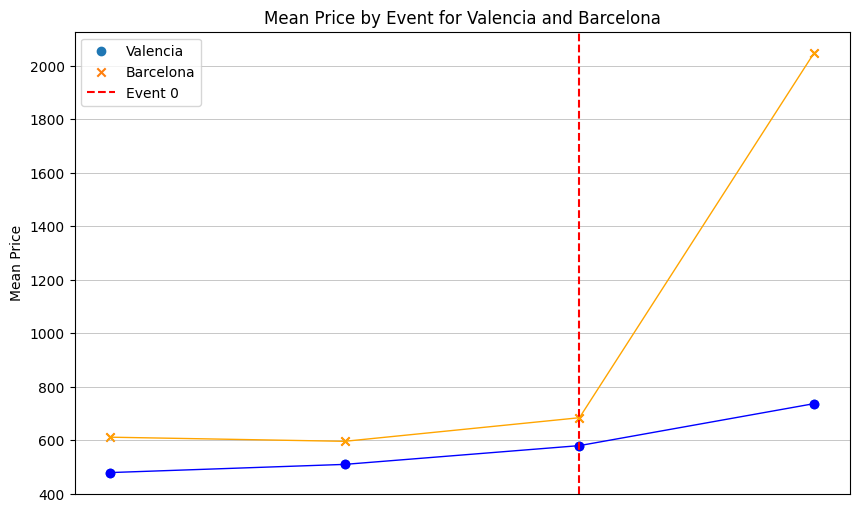

In [146]:
# Calculate the mean Price for each unique event and Barcelona combination
df_means = df.groupby(['event', 'barcelona'])['Price'].mean().reset_index()

# Filter the DataFrame for 'barcelona' == 0 and 'barcelona' == 1
barcelona_0 = df_means[df_means['barcelona'] == 0]
barcelona_1 = df_means[df_means['barcelona'] == 1]

# Create the plot with less bold labels and lines
plt.figure(figsize=(10, 6))
plt.scatter(x='event', y='Price', data=barcelona_0, label='Valencia', marker='o')
plt.scatter(x='event', y='Price', data=barcelona_1, label='Barcelona', marker='x')
plt.plot(barcelona_0['event'], barcelona_0['Price'], linestyle='-', marker='o', color='blue', lw=1)
plt.plot(barcelona_1['event'], barcelona_1['Price'], linestyle='-', marker='x', color='orange', lw=1)
plt.axvline(x=0, color='red', linestyle='--', label='Event 0')  # Add vertical line at 'event' == 0
plt.xlabel('')
plt.ylabel('Mean Price', fontweight='light')  # Less bold font for the y-axis label
plt.title('Mean Price by Event for Valencia and Barcelona', fontweight='light')  # Less bold font for the title
plt.legend()
plt.grid(True, linewidth=0.5)  # Thin grid lines

# Remove x-axis labels
plt.xticks([])

plt.show()